In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Aquifer_Petrignano.csv')

In [18]:
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB
None
Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25      

In [19]:
print(df.describe())

       Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
count            4199.000000               5168.000000   
mean                1.556633                -26.263723   
std                 5.217923                  3.319858   
min                 0.000000                -34.470000   
25%                 0.000000                -28.250000   
50%                 0.000000                -25.990000   
75%                 0.100000                -23.820000   
max                67.300000                -19.660000   

       Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  \
count               5184.000000               4199.000000   
mean                 -25.692926                 15.030293   
std                    3.214165                  7.794871   
min                  -33.710000                 -3.700000   
25%                  -27.620000                  8.800000   
50%                  -25.540000                 14.700000   
75%                  -23.430000                 21

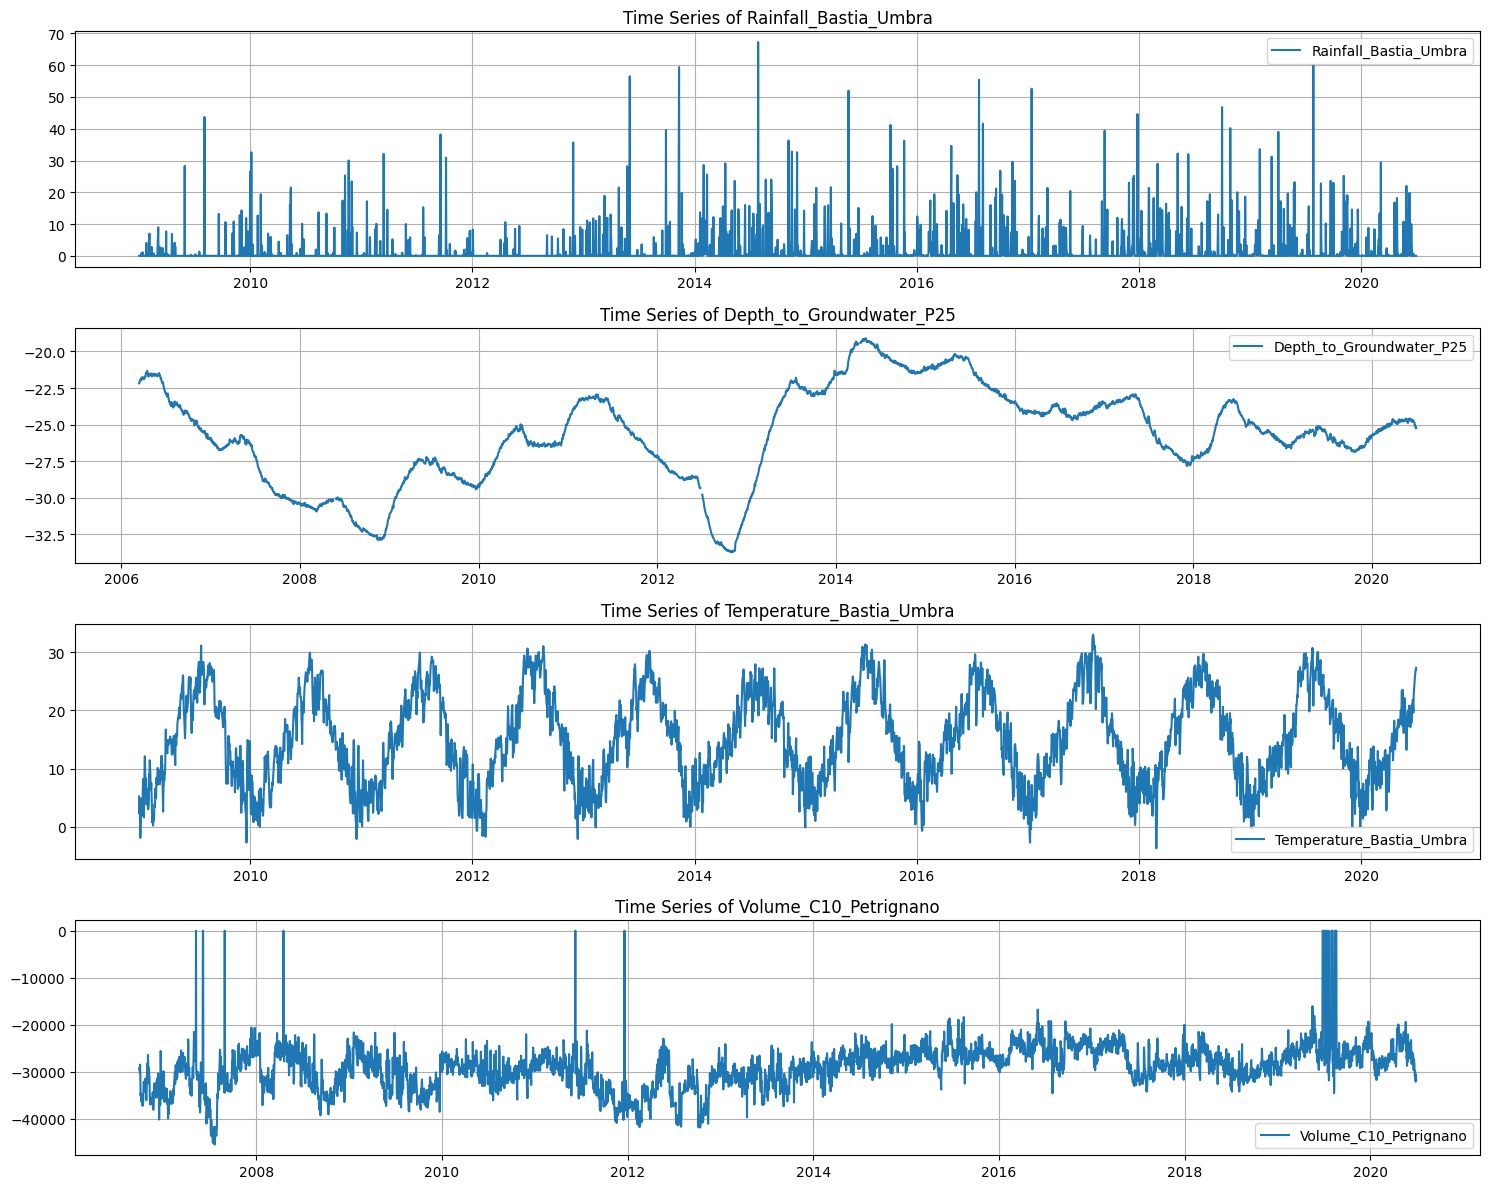

In [20]:
# Convert Date to datetime for plotting
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date')
df_plot = df.set_index('Date')

# Plotting
features_to_plot = ['Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra', 'Volume_C10_Petrignano']
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 1, i+1)
    plt.plot(df_plot.index, df_plot[feature], label=feature)
    plt.title(f'Time Series of {feature}')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

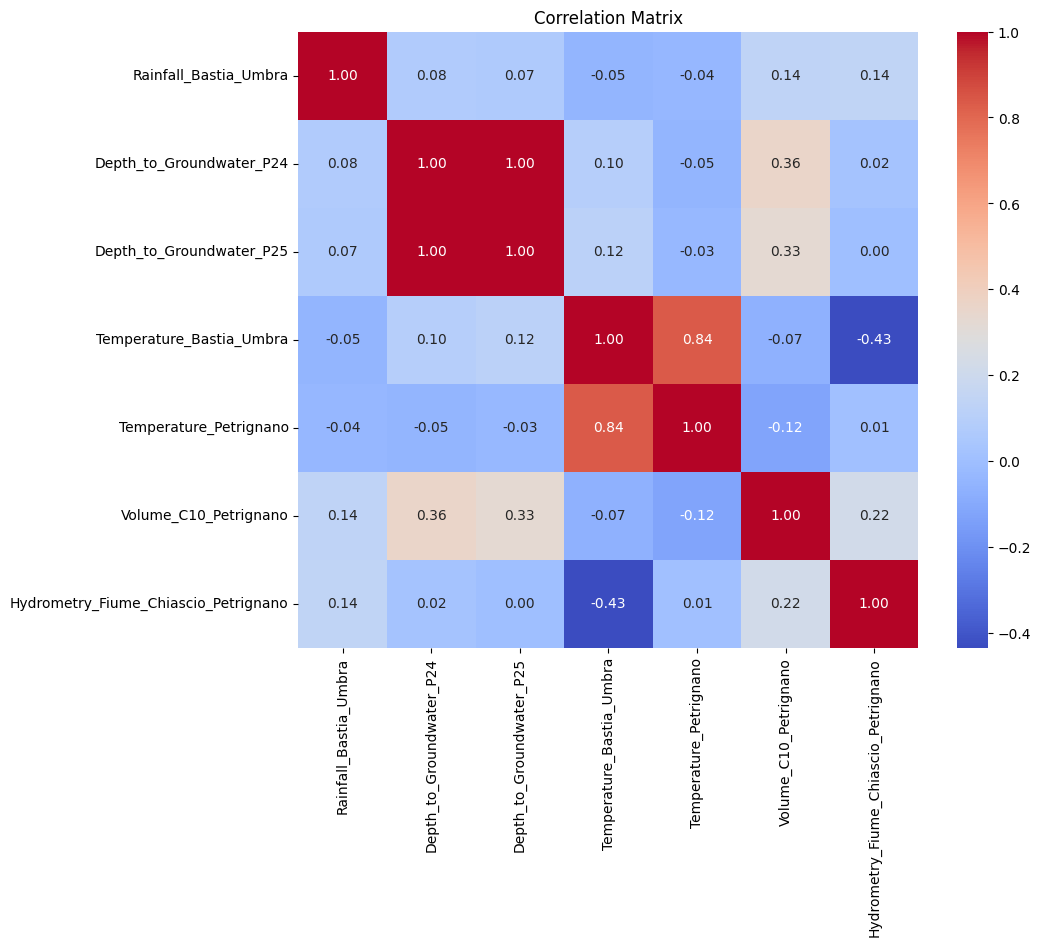

In [21]:
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

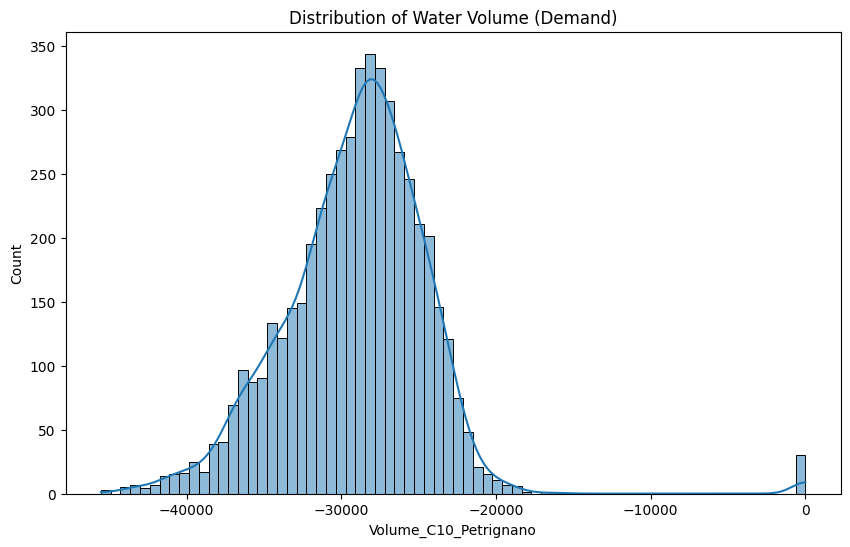

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Volume_C10_Petrignano'].dropna(), kde=True)
plt.title('Distribution of Water Volume (Demand)')
plt.show()

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [24]:
df = pd.read_csv('Aquifer_Petrignano.csv')

df['TEMP_AVG'] = df[['Temperature_Bastia_Umbra', 'Temperature_Petrignano']].mean(axis=1)

In [25]:
df = df.rename(columns={
    'Date': 'DATE',
    'Rainfall_Bastia_Umbra': 'RAIN',
    'Depth_to_Groundwater_P25': 'DEPTH',
    'Volume_C10_Petrignano': 'DEMAND'
})

df = df[['DATE', 'DEMAND', 'RAIN', 'TEMP_AVG', 'DEPTH']]

df['DATE'] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')
df = df.sort_values('DATE')
df['DEMAND'] = df['DEMAND'].abs()

df = df.interpolate(method='linear', limit_direction='both')
df = df.fillna(0)
df = df.set_index('DATE')

In [26]:
dataset = df.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [27]:
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 4)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\hansa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1
)

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0079 - val_loss: 0.0027
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 9/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 10/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 11/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 12/50
233/233 ━━━━━━━━━━━━━━━━━━━━

In [30]:
model.save('water_demand_lstm_model.h5')
joblib.dump(scaler, 'scaler.pkl')
print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
